In [1]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time
from equinox_module import training_MODEL, create_DeepONet, save_MODEL, load_DeepONet

In [2]:
SEED = 10

BRANCH_INPUT_DIM  = 1
BRANCH_WIDTH      = 20
BRANCH_DEPTH      = 4
BRANCH_ACTIVATION = 'tanh'

TRUNK_INPUT_DIM   = 2
TRUNK_WIDTH       = 20
TRUNK_DEPTH       = 4
TRUNK_ACTIVATION  = 'tanh'

DEEPONET_WIDTH    = 50
# sine, cosine, relu, tanh, gelu, swish

In [3]:
HYPER_MODEL = {"TRUNK": {"input_dim": TRUNK_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH, 
               "width": TRUNK_WIDTH,
               "depth": TRUNK_DEPTH-1, 
               "act_func": TRUNK_ACTIVATION},
               "BRANCH": {"input_dim": BRANCH_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH+1, 
               "width": BRANCH_WIDTH,
               "depth": BRANCH_DEPTH-1, 
               "act_func": BRANCH_ACTIVATION}
            }

In [4]:
key = jr.PRNGKey(SEED)
key, subkey_model, subkey_w, subkey_w_test = jr.split(key, num=4)

In [5]:
model = create_DeepONet(key=subkey_model, HYPER_MODEL=HYPER_MODEL)

In [6]:
LEARNING_RATE = 4e-4
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 50_000
PRINT_EVERY = 5_000

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'on'
LBFGS_MAXITER = 10_000
LBFGS_PRINT_EVERY = 1_000
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

In [7]:
def u_st(KAPPA, xt):
    return jnp.sin(xt[0]/KAPPA) * jnp.exp(-xt[1]/KAPPA)

T_FINAL = 1

num_x = 101
num_t = 51
kappa_low = 1/(4*jnp.pi)
kappa_upp = 1/(1*jnp.pi)

xx, tt = jnp.meshgrid(jnp.linspace(-1, 1, num_x), jnp.linspace(0, T_FINAL, num_t))
trunk_input_data = jnp.concatenate([jnp.reshape(xx,[-1,1]), jnp.reshape(tt,[-1,1])],axis=1)

In [8]:
branch_input_data = jr.uniform(key=subkey_w, minval=kappa_low, maxval=kappa_upp, shape=(100,))
trunk_output_data = vmap(lambda k: vmap(lambda xt: u_st(k,xt))(trunk_input_data))(branch_input_data)

In [9]:
branch_input_test = jr.uniform(key=subkey_w_test, minval=kappa_low, maxval=kappa_upp, shape=(200,))
xx_tt, tt_tt = jnp.meshgrid(jnp.linspace(-1, 1, 2*num_x), jnp.linspace(0, T_FINAL, 2*num_t))
trunk_input_test = jnp.concatenate([jnp.reshape(xx_tt,[-1,1]), jnp.reshape(tt_tt,[-1,1])],axis=1)
trunk_output_test = vmap(lambda k: vmap(lambda xt: u_st(k,xt))(trunk_input_test))(branch_input_test)

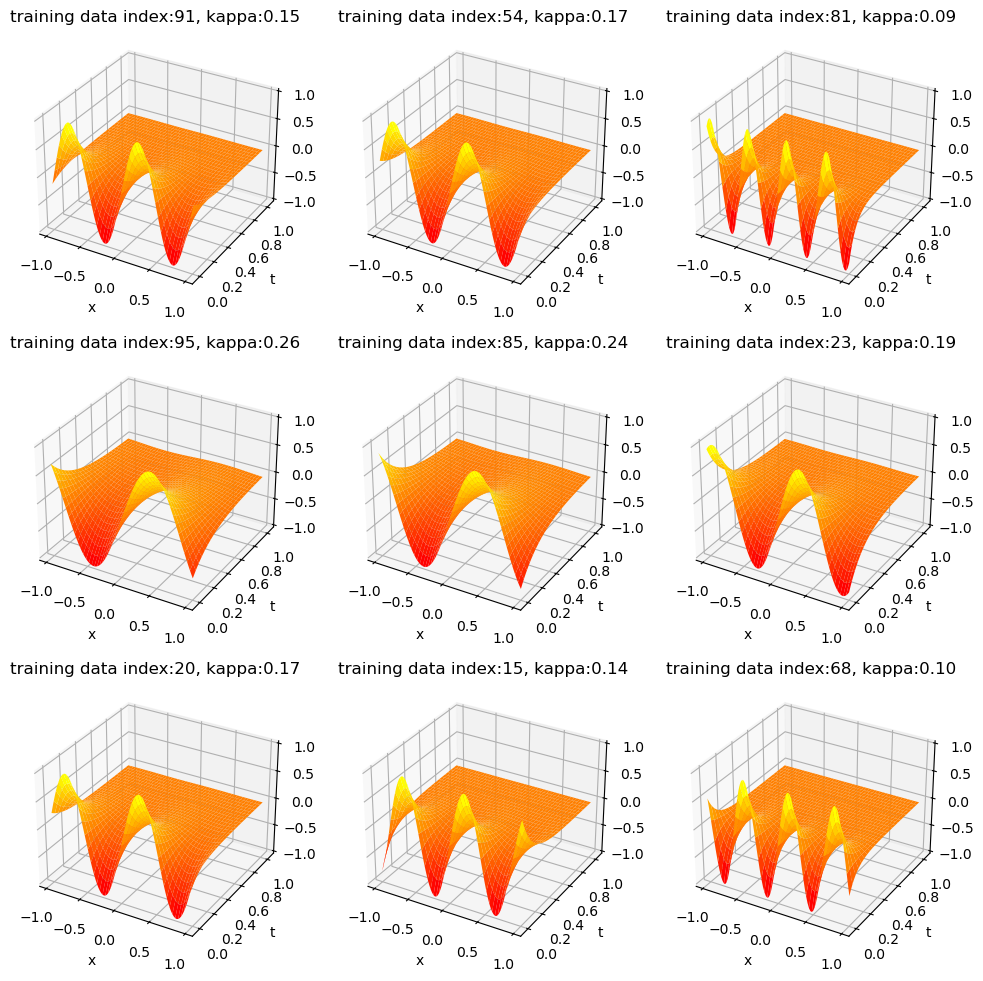

In [10]:
tr_idx_ALL = np.random.permutation(100)
fig, axes = plt.subplots(3, 3, figsize=(12, 12), subplot_kw=dict(projection='3d'))
axe = axes.flatten()
for i in range(len(axe)):
    tr_idx = tr_idx_ALL[i]
    axe[i].plot_surface(xx, tt, trunk_output_data[tr_idx].reshape(num_t,num_x), cmap='autumn', cstride=2, rstride=2)
    axe[i].set_xlabel('x')
    axe[i].set_ylabel('t')
    axe[i].set_xlim([-1.1, 1.1])
    axe[i].set_ylim([-0.1, T_FINAL + 0.1])
    axe[i].set_title(f'training data index:{tr_idx}, kappa:{branch_input_data[tr_idx]:.2f}')

In [11]:
HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [12]:
def loss_fn(model):
    residual = vmap(lambda f: vmap(lambda x: model(f,x))(trunk_input_data))(branch_input_data[:,None]) - trunk_output_data
    return jnp.mean(jnp.sum((residual)**2,axis=1) / jnp.sum(trunk_output_data**2,axis=1))
    # return jnp.mean(residual**2)

In [23]:
start_time = time.time()
model, log_loss, log_minloss = training_MODEL(model, loss_fn, HYPER_OPTIM)
end_time = time.time()

Selected Optimizer is [ adam ], Initial Learning Rate is 4.00e-04
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch   0K: loss = 2.6911e-04, minloss = 2.6911e-04, Time: 0.26s
Epoch   5K: loss = 3.2212e-04, minloss = 2.6911e-04, Time: 8.76s
Epoch  10K: loss = 3.6344e-04, minloss = 2.6911e-04, Time: 8.71s
Epoch  15K: loss = 6.4366e-04, minloss = 2.6911e-04, Time: 8.71s
Epoch  20K: loss = 5.9689e-04, minloss = 2.6911e-04, Time: 8.84s
Epoch  25K: loss = 3.8764e-04, minloss = 2.6911e-04, Time: 8.70s
Epoch  30K: loss = 3.6892e-04, minloss = 2.6911e-04, Time: 8.96s
Epoch  35K: loss = 4.8646e-04, minloss = 2.6911e-04, Time: 8.88s
Epoch  40K: loss = 9.3867e-04, minloss = 2.6911e-04, Time: 8.70s
Epoch  45K: loss = 8.3691e-04, minloss = 2.6911e-04, Time: 8.68s
Epoch  50K: loss = 4.5157e-04, minloss = 2.6911e-04, Time: 8.71s
----------------------------------------------

Avg. Relative L2 error     : 1.2710e-02


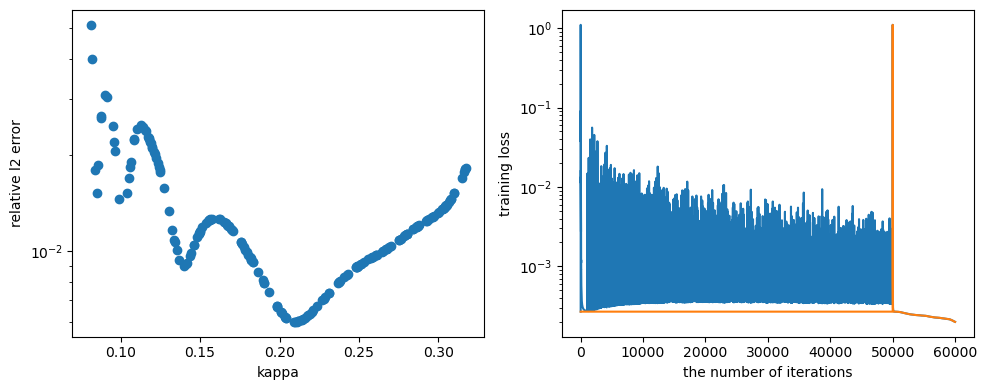

In [24]:
NN_pred_final = vmap(lambda f: vmap(lambda x: model(f,x))(trunk_input_test))(branch_input_test[:,None])
# vmin, vmax = jnp.min(y_tt), jnp.max(y_tt)
rel_l2_error = jnp.sqrt(jnp.sum((trunk_output_test - NN_pred_final)**2,axis=1) / jnp.sum(trunk_output_test**2,axis=1))
print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(branch_input_test,rel_l2_error)
axes[0].set_yscale('log')
axes[0].set_xlabel('kappa')
axes[0].set_ylabel('relative l2 error')
axes[1].semilogy(log_loss)
axes[1].semilogy(log_minloss)
axes[1].set_xlabel('the number of iterations')
axes[1].set_ylabel('training loss')
plt.tight_layout()
# plt.suptitle(title_str + '\n')
plt.show()

In [25]:
# rnd_idx = np.random.permutation(200)
# fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharey=True, sharex=True)
# axe = axes.flatten()
# for i in range(len(axe)//2):
#     tt_idx = rnd_idx[i]
#     axe[2*i].plot(branch_sensors,branch_input_test[tt_idx],'ob')
#     axe[2*i].set_title(f'test input function #{tt_idx+1}')
#     axe[2*i+1].plot(trunk_input_test,trunk_output_test[tt_idx],label='True')
#     axe[2*i+1].plot(trunk_input_test,trunk_output_test[tt_idx],'--',label='DeepONet')
#     axe[2*i+1].set_title(f'test output function #{tt_idx+1}')
#     axe[2*i+1].legend()
# fig.tight_layout()

In [ ]:
# save_MODEL('DeepONet_HeatEqn.eqx',HYPER_MODEL,model)

In [27]:
# loaded_model = load_DeepONet('DeepONet_Diff.eqx')